In [ ]:
# # Для работы в колабе раскоменьте эти строки
# !git clone https://github.com/HSE-LAMBDA/DeepGenerativeModels.git
# %cd DeepGenerativeModels/

# Этап 1. Загрузка данных
В данном задании вам предстоит работать с уже знакомым датасетом с лицами и генерировать новые лица с заданными аттрибутами

In [125]:
import sys; sys.path.append('../../utils/')
from datasets.celeba import CelebADataset
import torch
from torch import nn
import torch.nn.functional as F
from lpips_pytorch import LPIPS
from torchvision import transforms
from munch import Munch
import gc
from tqdm.auto import trange


## Setup
# Number of gpus available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = Munch()

# Spatial size of training images, images are resized to this size.
args.img_size = 64

args.batch_size = 8

# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])
# Load the dataset from file and apply transformations
dataset = CelebADataset(transform=transform, download=False)

# args.num_domains = 2*len(dataset.header)
# args.num_domains = len(dataset.header)
args.num_domais = 2  # male-female

# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False


# dataloader for batched data loading
dataloader = torch.utils.data.DataLoader(dataset,
                                                batch_size=args.batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)

In [14]:
dataset.header

['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

## Визуализация датасетов

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

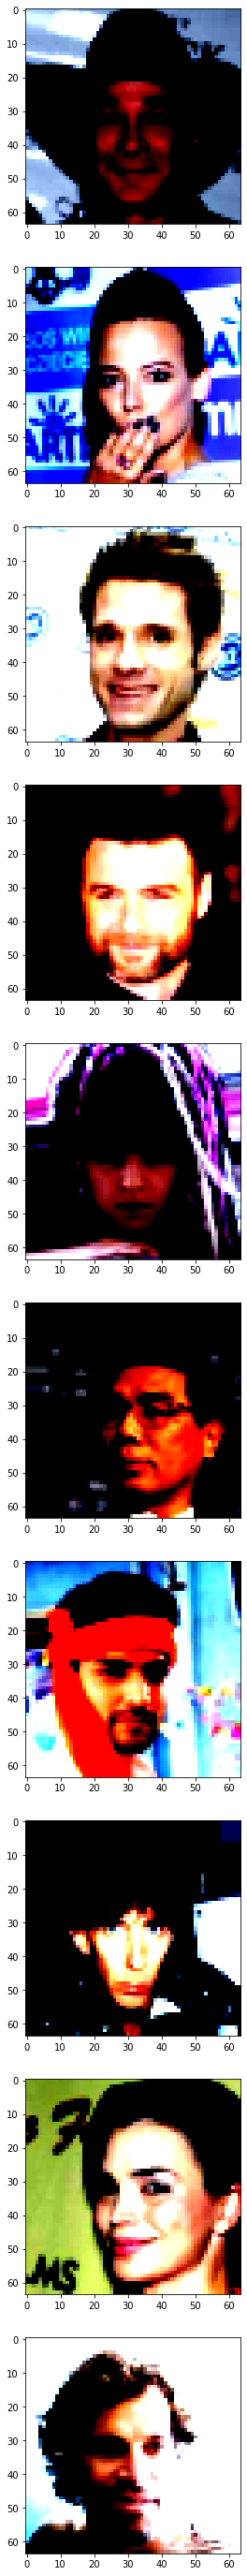

In [11]:
import matplotlib.pyplot as plt
import numpy as np

images_cnt = 10
plt.figure(figsize=(17,images_cnt*5))
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), images_cnt)):
    img, target = dataset[img_idx]
    # attributes dict for a given image. Contains 40 attributes
    attributes = {k:v for k,v in zip(dataset.header, target['attributes'].detach().cpu().numpy())}
    plt.subplot(images_cnt,1,i+1)
    plt.imshow(img.detach().cpu().numpy().transpose(1,2,0))

# Этап 2. Обучение модели
В рамках данного задания предлагается реализовать и обучить StarGAN для генережки лиц с заданными аттрибутами
![](assets/stargan.png)

Вам на выбор предлагается реализовать [StarGANv1](https://arxiv.org/pdf/1711.09020.pdf) (**до 4 баллов**) или [StarGANv2](https://arxiv.org/abs/1912.01865) (**до 7 баллов**)

Реализуем StarGANv2

- Generator

In [28]:
class ResBlock(nn.Module):
    def __init__(self, dim_in, dim_out, downsample=False, normalize=False):
        super().__init__()
        self.normalize = normalize
        self.downsample = downsample
        self.intermediate = dim_in == dim_out

        self.activation = nn.LeakyReLU(0.2)

        self.conv1 = nn.Conv2d(dim_in, dim_in, 3, 1, 1)
        self.norm1 = nn.InstanceNorm2d(dim_in, affine=True)
        self.conv2 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        self.norm2 = nn.InstanceNorm2d(dim_in, affine=True)

        self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if not self.intermediate:
            x = self.conv1x1(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        
        return x

    def _residual(self, x):
        if self.normalize:
            x = self.norm1(x)
        x = self.activation(x)
        x = self.conv1(x)

        if self.downsample:
            x = F.avg_pool2d(x, 2)

        if self.normalize:
            x = self.norm2(x)
        x = self.activation(x)
        x = self.conv2(x)
        
        return x

    def forward(self, x):
        return self._shortcut(x) + self._residual(x)


In [66]:
class AdaIN(nn.Module):
    def __init__(self, style_dim, dim_in):
        super().__init__()
        self.norm = nn.InstanceNorm2d(dim_in, affine=True)
        self.fc = nn.Linear(style_dim, dim_in*2)

    def forward(self, x, s):
        h = self.fc(s)
        h = h.view(h.size(0), h.size(1), 1, 1)
        gamma, beta = torch.chunk(h, chunks=2, dim=1)

        return (1 + gamma) * self.norm(x) + beta


class AdaINResBlock(nn.Module):
    def __init__(self, dim_in, dim_out, style_dim=64, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.intermediate = dim_in == dim_out

        self.activation = nn.LeakyReLU(0.2)

        self.conv1 = nn.Conv2d(dim_in, dim_out, 3, 1, 1)
        self.norm1 = AdaIN(style_dim, dim_in)
        self.conv2 = nn.Conv2d(dim_out, dim_out, 3, 1, 1)
        self.norm2 = AdaIN(style_dim, dim_out)

        self.conv1x1 = nn.Conv2d(dim_in, dim_out, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        if not self.intermediate:
            x = self.conv1x1(x)
        
        return x

    def _residual(self, x, s):
        x = self.norm1(x, s)
        x = self.activation(x)
        x = self.conv1(x)

        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')

        x = self.norm2(x, s)
        x = self.activation(x)
        x = self.conv2(x)
        
        return x

    def forward(self, x, s):
        return self._shortcut(x) + self._residual(x, s)


In [105]:
class Generator(nn.Module):
    def __init__(self, img_size=64, style_dim=64, max_conv_dim=512):
        super().__init__()

        self.blocks_count = 2
        self.style_dim = style_dim
        self.max_conv_dim = max_conv_dim

        self.dim_in = 256
        self.in_conv = nn.Conv2d(3, self.dim_in, 3, 1, 1)
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.out_conv = nn.Conv2d(self.dim_in, 3, 1, 1, 0)

        self._init_encoder_and_decoder()

    def _init_encoder_and_decoder(self):
        curr_dim_in = self.dim_in
        for _ in range(self.blocks_count):
            curr_dim_out = min(curr_dim_in*2, self.max_conv_dim)
            self.encoder.append(ResBlock(curr_dim_in, curr_dim_out, downsample=True, normalize=True))
            self.decoder.insert(0, AdaINResBlock(curr_dim_out, curr_dim_in, self.style_dim, upsample=True))
            curr_dim_in = curr_dim_out

        for _ in range(self.blocks_count // 2):
            self.encoder.append(ResBlock(curr_dim_out, curr_dim_out, normalize=True))
            self.decoder.insert(0, AdaINResBlock(curr_dim_out, curr_dim_out, self.style_dim))

    def forward(self, x, s):
        x = self.in_conv(x)

        for encoder_block in self.encoder:
            x = encoder_block(x)

        for decoder_block in self.decoder:
            x = decoder_block(x, s)

        return self.out_conv(x)


- MappingNetwork

In [140]:
class MappingNetwork(nn.Module):
    def __init__(self, latent_dim=16, style_dim=64, domains_num=2):
        super().__init__()
        self.shared_mlp = MappingNetwork._get_shared_mlp(latent_dim, style_dim)
        self.domain_mlps = MappingNetwork._get_domain_mlps(style_dim, domains_num)

    @staticmethod
    def _get_shared_mlp(latent_dim, style_dim):
        shared_layers = [
            nn.Linear(latent_dim, 512),
            nn.ReLU()
        ]
        for _ in range(3):
            shared_layers.extend([
                nn.Linear(512, 512),
                nn.ReLU()
            ])

        return nn.Sequential(*shared_layers)

    @staticmethod
    def _get_domain_mlps(style_dim, domains_num):
        mlps = nn.ModuleList()
        for _ in range(domains_num):
            mlps.append(nn.Sequential(
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, style_dim)
            ))

        return mlps

    def forward(self, z, y):
        h = self.shared_mlp(z)
        domains_out = []
        for domain_mlp in self.domain_mlps:
            domains_out.append(domain_mlp(h))
        domains_out = torch.stack(domains_out, dim=1)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        print(idx)
        style = domains_out[idx, y]

        return style
        

- StyleEncoder

In [170]:
class StyleEncoder(nn.Module):
    def __init__(self, img_size=64, style_dim=64, num_domains=2, max_conv_dim=512):
        super().__init__()

        self.shared_mlp = self._get_shared_mlp(img_size, max_conv_dim)
        self.domain_mlps = self._get_domain_mlps(style_dim, num_domains)

    def _get_shared_mlp(self, img_size, max_conv_dim):
        blocks_count = int(np.log2(img_size)) - 2
        curr_dim_in = 256
        blocks = [nn.Conv2d(3, curr_dim_in, 3, 1, 1)]
        for _ in range(blocks_count):
            curr_dim_out = min(curr_dim_in * 2, max_conv_dim)
            blocks.append(ResBlock(curr_dim_in, curr_dim_out, downsample=True))
            curr_dim_in = curr_dim_out
        self._dim_out = curr_dim_out

        blocks.extend([
            nn.LeakyReLU(0.2),
            nn.Conv2d(curr_dim_out, curr_dim_out, 4, 1, 0),
            nn.LeakyReLU(0.2),
        ])

        return nn.Sequential(*blocks)

    def _get_domain_mlps(self, style_dim, num_domains):
        domain_mlps = nn.ModuleList()
        for _ in range(num_domains):
            domain_mlps.append(nn.Linear(self._dim_out, style_dim))

        return domain_mlps

    def forward(self, x, y):
        h = self.shared_mlp(x)
        h = h.view(h.size(0), -1)
        domains_out = []
        for domain_mlp in self.domain_mlps:
            domains_out += [domain_mlp(h)]
        domains_out = torch.stack(domains_out, dim=1) 
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        style = domains_out[idx, y] 

        return style


- Discriminator

In [192]:
class Discriminator(nn.Module):
    def __init__(self, img_size=64, num_domains=2, max_conv_dim=512):
        super().__init__()

        self.discriminator = Discriminator._get_discriminator(img_size, max_conv_dim, num_domains)

    @staticmethod
    def _get_discriminator(img_size, max_conv_dim, num_domains):
        blocks_count = int(np.log2(img_size)) - 2
        curr_dim_in = 256
        blocks = [nn.Conv2d(3, curr_dim_in, 3, 1, 1)]
        for _ in range(blocks_count):
            curr_dim_out = min(curr_dim_in * 2, max_conv_dim)
            blocks.append(ResBlock(curr_dim_in, curr_dim_out, downsample=True))
            curr_dim_in = curr_dim_out

        blocks.extend([
            nn.LeakyReLU(0.2),
            nn.Conv2d(curr_dim_out, curr_dim_out, 4, 1, 0),
            nn.LeakyReLU(0.2),
            nn.Conv2d(curr_dim_out, num_domains, 1, 1, 0)
        ])

        return nn.Sequential(*blocks)

    def forward(self, x, y):
        domains_out = self.discriminator(x)
        domains_out = domains_out.view(domains_out.size(0), -1)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        domains_out = domains_out[idx, y] 

        return domains_out


In [ ]:
# nets = Munch()
# nets.generator = ???
# nets.mapping_network = ???
# nets.style_encoder = ???
# nets.discriminator = ???

# Evaluation

In [ ]:
lpips = LPIPS()

In [29]:
from tqdm.auto import trange
test_iters = 100
values = []
for i in trange(test_iters):
    # fetch images and labels
    x_real, _ = next(iter(dataloader))
    x_ref, _ = next(iter(dataloader))
    x_ref2, _ = next(iter(dataloader))
    batch_size = x_real.shape[0]
    y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size)) # целевой домен
    y_org = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size)) # ваш домен
    
    x_real, x_ref, x_ref2 = [x.to(device).float() for x in [x_real, x_ref, x_ref2]]
    y_trg, y_org = [x.to(device).long() for x in [y_trg, y_org]]
    
    x_fake = ??? # YOUR CODE IS HERE

    values.append(lpips(x_fake.cpu(), x_real.cpu()).squeeze().item())

assert(np.mean(values) < 1.3)

In [30]:
np.mean(values)

0.6601867008209229

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


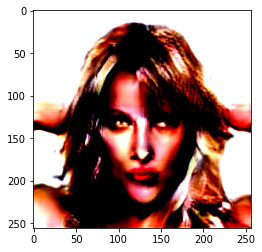

In [34]:
with torch.no_grad():
    z_trg = torch.randn((batch_size, args.latent_dim)).to(device)
    s_trg = nets.mapping_network(z_trg, y_trg)
#     s_trg = nets.style_encoder(x_ref2, y_trg)
    x_fake = nets.generator(x_real, s_trg)
plt.imshow(x_fake[1].permute(1,2,0).detach().cpu().numpy())

# Этап 3(\*). Дополнительный анализ

* Анализ латентного пространства и визуально качественный результат - **2 балла**
* Текстовое ревью решения и предложения возможных улучшений - **1 балл**